In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150

In [2]:
pudl_engine  = pudl.db_connect_pudl()

### Pulling the required tables

In [3]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9, 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [4]:
# Convert the generators_eia860 table into a dataframe
g8 = analysis.simple_select('generators_eia860', pudl_engine)

# In order to use the energy source associated with each generator
g8_es = g8[['plant_id','generator_id', 'energy_source_1']]
g8_es = g8_es.rename(columns={'energy_source_1': 'energy_source'})
g8_es.drop_duplicates(['plant_id','generator_id'], inplace=True)

# In order to use the capacity of each generator
g8 = g8[['plant_id','generator_id','nameplate_capacity_mw','summer_capacity_mw','winter_capacity_mw','year']]
g8.rename(columns={'year': 'report_date'},inplace=True)

In [5]:
# # Cheating to duplicate 2015 EIA860 capacity factor data for 2016:
g8_2016 = g8.loc[g8['report_date'] == 2015]
g8_2016.report_date.replace([2015], [2016], inplace=True)
g8 = g8_2016.append(g8)

/home/alana/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [6]:
# Convert the fuel_receipts_costs_eia923 table into a dataframe
frc9 = analysis.simple_select('fuel_receipts_costs_eia923', pudl_engine)
frc9['fuel_cost'] = (frc9['fuel_quantity'] * frc9['average_heat_content'] * frc9['fuel_cost_per_mmbtu'])

In [7]:
# Get yearly fuel cost by plant_id, year and energy_source
frc9_summed = analysis.yearly_sum_eia(frc9 , 'fuel_cost', columns=['plant_id','report_date','energy_source'])
frc9_summed = frc9_summed.reset_index()

In [8]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_plant_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date'])
bf9_plant_summed.reset_index(inplace=True)

In [9]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = analysis.simple_select('boiler_generator_assn_eia860', pudl_engine)
bga8.drop(['id','operator_id'],axis=1, inplace=True)
bga8.drop_duplicates(['plant_id','boiler_id','generator_id'],inplace=True)

In [10]:
# get the primary fuel for each plant (to be used to combine plants that have unassociated generators)
gf9 = analysis.simple_select('generation_fuel_eia923', pudl_engine)
primary_fuel9 = analysis.primary_fuel_gf_eia923(gf9).rename(columns={'year':'report_date'})

### Generating Capacity Factor

In [11]:
# merge the generation and capacity to calculate capacity factor
capacity_factor = g9_summed.merge(g8, on=['plant_id','generator_id','report_date'])
capacity_factor['capacity_factor'] =\
            capacity_factor['net_generation_mwh']/(capacity_factor['nameplate_capacity_mw']*8760)

In [12]:
# Replace unrealistic capacity factors with NaN: < 0 or > 1.5
capacity_factor.loc[capacity_factor['capacity_factor'] < 0, 'capacity_factor'] = np.nan
capacity_factor.loc[capacity_factor['capacity_factor'] >= 1.5, 'capacity_factor'] = np.nan

### Generating Fuel Cost

In [13]:
# Merge the generation table with the generator table to include energy_source
net_gen = g9_summed.merge(g8_es, how='left', on=['plant_id','generator_id'])
fuel_cost_per_mwh = net_gen.merge(frc9_summed,how='left',on=['plant_id','report_date','energy_source'])

In [14]:
# Sum the net generation by fuel type and year for each plant to calculation proportion of generation by each generator
net_gen_by_energy = fuel_cost_per_mwh.groupby(['plant_id', 'report_date', 'energy_source'])[["net_generation_mwh"]].sum()
net_gen_by_energy = net_gen_by_energy.reset_index()
fuel_cost_per_mwh = fuel_cost_per_mwh.merge(net_gen_by_energy, how='left', on=['plant_id', 'report_date', 'energy_source'])

In [15]:
# Calculate proportion of annual plant generation by each generator
fuel_cost_per_mwh['proportion_generation_by_generator'] = (fuel_cost_per_mwh.net_generation_mwh_x)/(fuel_cost_per_mwh.net_generation_mwh_y)
del fuel_cost_per_mwh['net_generation_mwh_y']
fuel_cost_per_mwh.rename(columns={'net_generation_mwh_x': 'net_generation_mwh'}, inplace=True)

In [16]:
# Calculate cost of fuel by generator
fuel_cost_per_mwh['fuel_cost_by_generator'] = fuel_cost_per_mwh['fuel_cost']*fuel_cost_per_mwh['proportion_generation_by_generator']
# Remove fuel_cost_by_generator values that are negative
fuel_cost_per_mwh.loc[fuel_cost_per_mwh['fuel_cost_by_generator'] < 0, 'fuel_cost_by_generator'] = np.nan
# Calculate fuel cost per mwh - will be the same for generators of same energy_source each year
fuel_cost_per_mwh['fuel_cost_per_mwh'] = fuel_cost_per_mwh['fuel_cost_by_generator'] / fuel_cost_per_mwh['net_generation_mwh']
# Remove fuel_cost_per_mwh values that are negative
fuel_cost_per_mwh.loc[fuel_cost_per_mwh['fuel_cost_per_mwh'] < 0, 'fuel_cost_per_mwh'] = np.nan

### Generating Heat Rate

##### Unassociated Generators

In [17]:
# This section generates heat rate from the generators
# of the plants that have any generators that are not
# included in the boiler generator association table (860)
# Because there are missing generators in the bga table,
# without lumping all of the heat input and generation
# from these plants together, the heat rates were off. 
# The vast majority of missing generators from the bga
# table seem to be the gas tubrine from combine cycle plants.
# This was generating heat rates for the steam generators
# alone, therefor much too low.

In [18]:
# All cenerators from the Boiler Generator Association table (860)
gens8 = bga8.drop_duplicates(subset=['plant_id','generator_id'])
# All cenerators from the generation table (923)
gens9 = g9_summed.drop_duplicates(subset=['plant_id','generator_id','report_date'])

# See which generators are missing from the bga table
gens = gens9.merge(gens8, on=['plant_id', 'generator_id'], how="left")
gens.boiler_id = gens.boiler_id.astype(str)
gens['boiler_generator_assn'] = np.where(gens['boiler_id']=='nan', False, True)

# Create a list of plants that include any generators that are not in the bga table
unassociated_plants = gens[gens['boiler_generator_assn'] == False].\
                      drop_duplicates(subset=['plant_id','report_date']).\
                      drop(['generator_id', 'net_generation_mwh','boiler_id','boiler_generator_assn'],axis=1)
unassociated_plants['plant_assn'] = False

# Using these unassociated_plants, lable all the generators that
# are a part of plants that have generators that are not included
# in the bga table
gens = gens.merge(unassociated_plants, on=['plant_id','report_date'],how='left')
gens['plant_assn'] = gens.plant_assn.fillna(value=True)

# Get a list of generators from plants with unassociated plants
gens_unassn_plants = gens[gens['plant_assn'] == False]

# Sum the yearly net generation for these plants
gup_gb = gens_unassn_plants.groupby(by=['plant_id','report_date'])
gens_unassn_plants_summed = gup_gb.agg({'net_generation_mwh': np.sum})
gens_unassn_plants_summed.reset_index(inplace=True)

# Pull in mmbtu to calculate heat rate by plant
unassn_plants = gens_unassn_plants_summed.merge(bf9_plant_summed, on=['plant_id','report_date'])
unassn_plants['heat_rate_mmbtu_mwh'] = unassn_plants['fuel_consumed_mmbtu'] / unassn_plants['net_generation_mwh']

# Merge these plant level heat heat rates with the unassociated generators
# Assign heat rates to generators across the plants with unassociated generators
heat_rate_unassn = gens_unassn_plants.merge(unassn_plants[['plant_id','report_date','heat_rate_mmbtu_mwh']],
                                            on=['plant_id','report_date'],how='left')
heat_rate_unassn.drop(['boiler_id','boiler_generator_assn'],axis=1,inplace=True)

#### Associated Generators

In [19]:
# This section generates heat rate from the generators of
# the plants that have any generators that are included in
# the boiler generator association table (860)

In [20]:
generation_w_boilers = g9_summed.merge(bga8,how='left',on=['plant_id','generator_id'])

# get net generation per boiler
gb1 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id'])
generation_w_boilers_summed = gb1.agg({'net_generation_mwh': np.sum})
generation_w_boilers_summed.reset_index(inplace=True)
generation_w_boilers_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler'}, inplace=True)

# get the generation per boiler/generator combo
gb2 = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id','generator_id'])
generation_w_bg_summed = gb2.agg({'net_generation_mwh': np.sum})
generation_w_bg_summed.reset_index(inplace=True)
generation_w_bg_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler_gen'}, inplace=True)

# squish them together
generation_w_boilers_summed = generation_w_boilers_summed.merge(generation_w_bg_summed,
                                                                how='left', on=['plant_id','report_date','boiler_id'])

# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)

bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])
bg = bg.merge(generation_w_boilers_summed, how='left', on=['plant_id','report_date', 'boiler_id', 'generator_id'])

# Use the proportion of the generation of each generator to allot mmBTU
bg['proportion_of_gen_by_boil_gen'] = bg['net_generation_mwh_boiler_gen'] / bg['net_generation_mwh_boiler']
bg['fuel_consumed_mmbtu_per_generator'] = bg['proportion_of_gen_by_boil_gen'] * bg['fuel_consumed_mmbtu']

# Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
bg_summed = bg_gb.agg({'fuel_consumed_mmbtu_per_generator':np.sum})
bg_summed.reset_index(inplace=True)

# Calculate heat rate
heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu_per_generator'] / heat_rate['net_generation_mwh']

# Importing the plant association tag to filter out the
# generators that are a part of plants that aren't in the bga table
heat_rate = heat_rate.merge(gens[['plant_id','report_date','generator_id','plant_assn']], on=['plant_id','report_date','generator_id'])
heat_rate_assn = heat_rate[heat_rate['plant_assn'] == True]

#### Pull the Associated and Unassociated Generators

In [21]:
heat_rate_all = heat_rate_assn.append(heat_rate_unassn)
# Reassign heat rate values to nan for rows with heat rates less than 5
heat_rate_all.loc[heat_rate_all['heat_rate_mmbtu_mwh'] < 5, 'heat_rate_mmbtu_mwh'] = np.nan

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


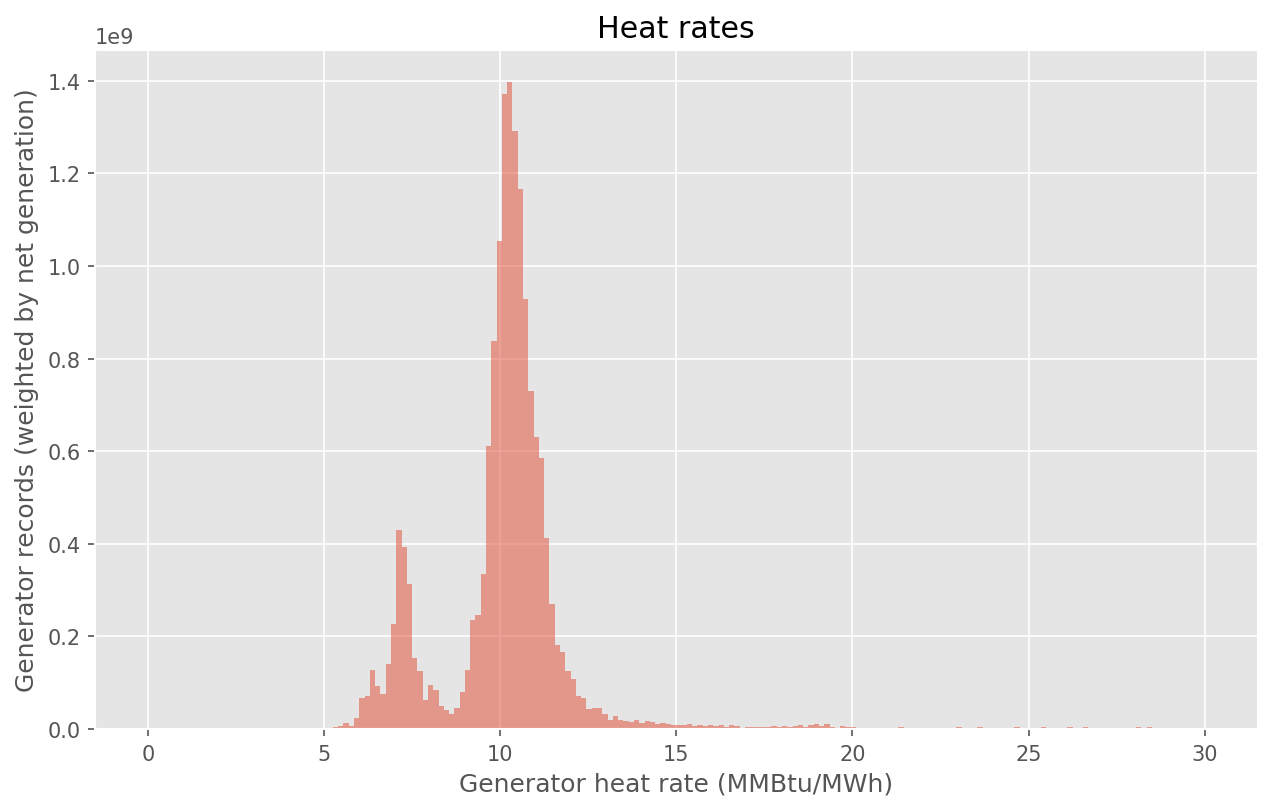

In [22]:
plt.hist(heat_rate_all.heat_rate_mmbtu_mwh, range=[0,30],bins=200,weights=heat_rate_all.net_generation_mwh, alpha=0.5)
plt.xlabel('Generator heat rate (MMBtu/MWh)')
plt.ylabel("Generator records (weighted by net generation)")
plt.title("Heat rates")
plt.show()

### Merge fields together

In [23]:
mcoe_by_generator = fuel_cost_per_mwh.merge(heat_rate_all,on=['plant_id','report_date','generator_id'])

In [24]:
mcoe_by_generator = mcoe_by_generator.merge(capacity_factor, on=['plant_id','report_date','generator_id'])

In [25]:
# Drop extraneous net_generation columns, and fuel_cost column because it is sum for whole plant
mcoe_by_generator.drop('net_generation_mwh_y', axis=1, inplace=True)
mcoe_by_generator.drop('net_generation_mwh_x', axis=1, inplace=True)
mcoe_by_generator.drop('fuel_cost', axis=1, inplace=True)

# Filter to include only plants >= 50 MW

In [26]:
# Now, let's grab only those plants larger than 50MW
mcoe_by_generator = mcoe_by_generator[mcoe_by_generator['nameplate_capacity_mw']>=50]

### Let's look at some data

In [27]:
mcoe_by_generator[mcoe_by_generator['plant_id'] == 676]

,plant_id,report_date,generator_id,energy_source,proportion_generation_by_generator,fuel_cost_by_generator,fuel_cost_per_mwh,fuel_consumed_mmbtu_per_generator,heat_rate_mmbtu_mwh,plant_assn,net_generation_mwh,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
1562,676,2011,3,BIT,1.000000,7.038856e+07,51.447081,1.476694e+07,10.793174,True,1368174.0,363.8,342.0,342.0,0.429313
1563,676,2011,5ST,NG,0.986687,7.955764e+07,99.499664,0.000000e+00,NaN,True,799577.0,120.0,123.0,121.0,0.760633
1564,676,2011,ST1,NG,-0.000485,NaN,NaN,1.356115e+04,NaN,True,-393.0,103.5,85.0,85.0,NaN
1565,676,2011,ST2,NG,0.013797,1.112506e+06,99.499664,1.610822e+05,14.406781,True,11181.0,126.0,106.0,106.0,0.010130
1566,676,2012,3,BIT,1.000000,5.794116e+07,45.700328,1.377339e+07,10.863581,True,1267850.0,363.8,342.0,342.0,0.397833
1567,676,2012,5ST,NG,0.980416,6.057154e+07,72.149001,0.000000e+00,NaN,True,839534.0,120.0,123.0,121.0,0.798643
1568,676,2012,ST1,NG,0.000044,2.741662e+03,72.149001,1.478202e+04,389.000395,True,38.0,103.5,85.0,85.0,0.000042
1569,676,2012,ST2,NG,0.019540,1.207197e+06,72.149001,2.432673e+05,14.539046,True,16732.0,126.0,106.0,106.0,0.015159
1570,676,2013,3,BIT,1.000000,5.502671e+07,41.997238,1.440091e+07,10.990996,True,1310246.0,363.8,342.0,342.0,0.411137
1571,676,2013,5ST,NG,0.996327,6.579369e+07,90.538869,0.000000e+00,NaN,True,726690.0,120.0,123.0,121.0,0.691296


/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/home/alana/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


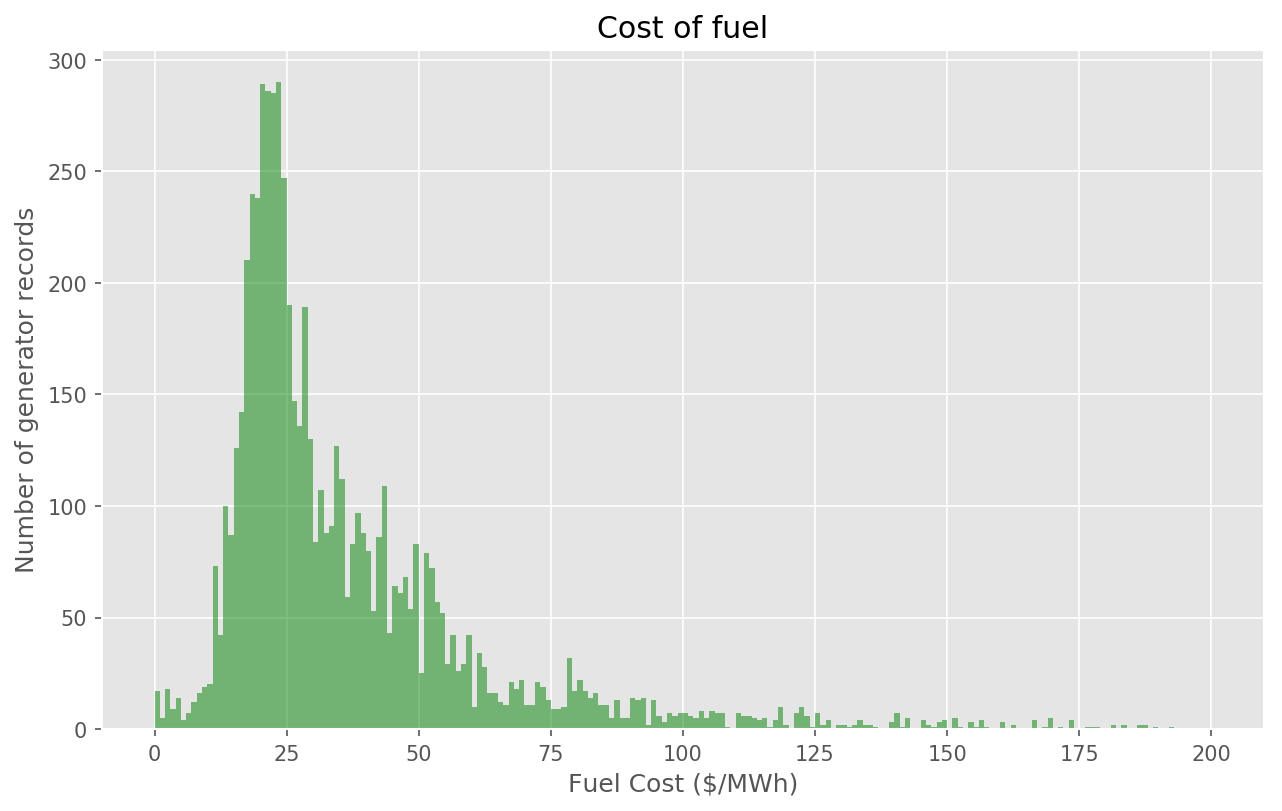

In [28]:
#quick look at spread in fuel_cost_per_mwh
plt.hist(mcoe_by_generator.fuel_cost_per_mwh, range=(0,200), bins=200, alpha=0.5, color='green')
plt.xlabel("Fuel Cost ($/MWh)")
plt.ylabel("Number of generator records")
plt.title("Cost of fuel")
plt.legend();

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)
/home/alana/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


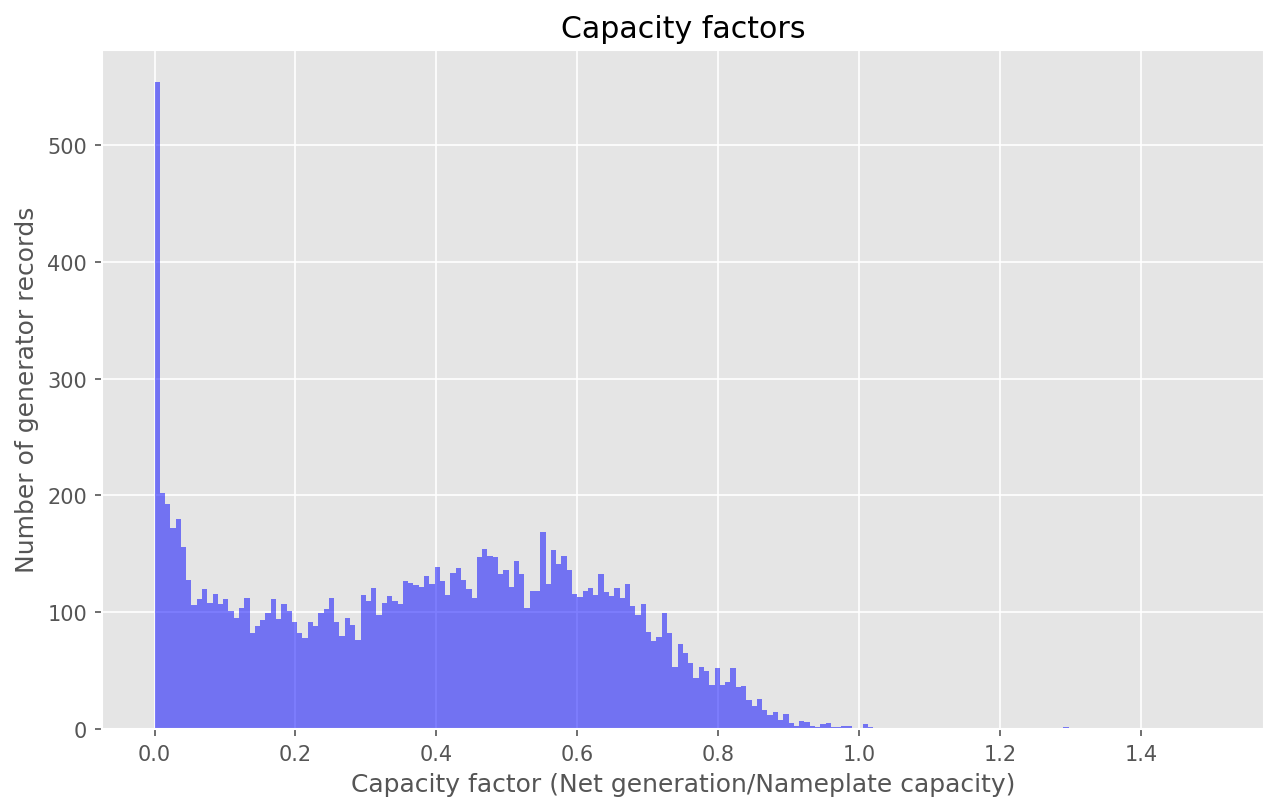

In [29]:
#quick look at capacity factors
plt.hist(mcoe_by_generator.capacity_factor, range=(0,1.5), bins=200, alpha=0.5, color='blue')
plt.xlabel("Capacity factor (Net generation/Nameplate capacity)")
plt.ylabel("Number of generator records")
plt.title("Capacity factors")
plt.legend();

In [30]:
mcoe_by_generator.fuel_cost_per_mwh.describe()

count     6536.000000
mean        57.174650
std        732.162395
min          0.007643
25%         20.736752
50%         27.973872
75%         45.099173
max      50790.726912
Name: fuel_cost_per_mwh, dtype: float64

In [31]:
mcoe_annotations = pd.read_csv('mcoe_field_annotations.csv')
mcoe_notes = pd.read_csv('mcoe_notes.csv')

In [32]:
xlsx_writer = pd.ExcelWriter('EIA_mcoe_2011-2015.xlsx')
mcoe_by_generator.to_excel(xlsx_writer, sheet_name='MCOE by Generator', index=False, na_rep='NA')
mcoe_annotations.to_excel(xlsx_writer, sheet_name='MCOE Annotations', index=False)
mcoe_notes.to_excel(xlsx_writer, sheet_name='MCOE Notes', index=False)

xlsx_writer.save()

In [33]:
mcoe_by_generator.sample(3)

,plant_id,report_date,generator_id,energy_source,proportion_generation_by_generator,fuel_cost_by_generator,fuel_cost_per_mwh,fuel_consumed_mmbtu_per_generator,heat_rate_mmbtu_mwh,plant_assn,net_generation_mwh,nameplate_capacity_mw,summer_capacity_mw,winter_capacity_mw,capacity_factor
5344,2727,2014,2,BIT,0.213956,5.699385e+07,28.314114,1.934559e+07,9.610743,True,2012913.0,350.0,380.0,380.0,0.656527
8795,6558,2012,3,NG,0.000000,0.000000e+00,NaN,NaN,NaN,True,0.0,55.0,50.0,50.0,0.000000
9646,8048,2015,1,RFO,0.540544,NaN,NaN,1.619578e+07,11.001871,True,1472093.0,556.2,521.0,524.0,0.302134
